# Parameter Inference

EOS can infer parameters based on a database of experimental or theoretical constraints and its built-in observables.
The examples in this notebook illustrate how to find a specific constraint from the list of all built-in observables,
construct an [eos.Analysis](api/python.rst#eos.Analysis) object that represents the statistical analysis,
and infer mean value and standard deviation of a list of parameters through optimization or Monte Carlo methods.

## Listing the built-in Constraints

The full list of built-in constraints for the most-recent EOS release is available online [here](https://eos.github.io/doc/constraints). You can also show this list using the [eos.Constraints](api/python.rst#eos.Constraints) class.  Searching for a specific constraint is possible by filtering for specific strings in the constraint name’s *prefix*, *name*, or *suffix* parts. The following example only shows constraints that contain a `'->D'` in the prefix part:

In [1]:
import eos
eos.Constraints(prefix='->D')

qualified name,observables,type,reference
B->D::f_++f_0@FNAL+MILC:2015B,... B->D::f_0(q2)B->D::f_+(q2),MultivariateGaussian,FNAL+MILC:2015B
B->D::f_++f_0@HPQCD:2015A,... B->D::f_0(q2)B->D::f_+(q2),MultivariateGaussian,HPQCD:2015A
B->D::f_+@FKKM:2008A,... B->D::f_+(q2),Gaussian,FKKM:2008A
"B->D^(*)::FormFactors[f_+,f_0,A_0,A_1,A_2,V,T_1,T_2,T_23]@GKvD:2018A",... B->D^*::V(q2)B->D^*::A_1(q2)B->D::f_+(q2)B->D::f_0(q2)B->D^*::T_2(q2)B->D^*::A_0(q2)B->D^*::T_23(q2)B->D^*::T_1(q2)B->D^*::A_2(q2),MultivariateGaussian(Covariance),GKvD:2018A
"B->D^(*)::FormFactors[f_+,f_0,f_T,A_0,A_1,A_2,V,T_1,T_2,T_23]@GKvD:2018A",... B->D^*::V(q2)B->D^*::A_1(q2)B->D::f_+(q2)B->D::f_0(q2)B->D::f_T(q2)B->D^*::T_2(q2)B->D^*::A_0(q2)B->D^*::T_23(q2)B->D^*::T_1(q2)B->D^*::A_2(q2),MultivariateGaussian(Covariance),GKvD:2018A
"B->D^(*)::FormFactors[parametric,LCSRLattice]@GKvD:2018A",... B->D^*::alpha^T1_0@BSZ2015B->D^*::alpha^T23_2@BSZ2015B->D^*::alpha^A1_2@BSZ2015B->D::alpha^fT_1@BSZ2015B->D^*::alpha^A1_0@BSZ2015B->D::alpha^fT_2@BSZ2015B->D^*::alpha^A0_0@BSZ2015B->D^*::alpha^T23_1@BSZ2015B->D^*::alpha^A0_2@BSZ2015B->D^*::alpha^V_2@BSZ2015B->D^*::alpha^V_0@BSZ2015B->D::alpha^f0_2@BSZ2015B->D::alpha^f0_1@BSZ2015B->D^*::alpha^T2_2@BSZ2015B->D^*::alpha^A12_2@BSZ2015B->D::alpha^fT_0@BSZ2015B->D^*::alpha^T23_0@BSZ2015B->D^*::alpha^T1_2@BSZ2015B->D^*::alpha^A0_1@BSZ2015B->D::alpha^f+_2@BSZ2015B->D^*::alpha^T2_1@BSZ2015B->D^*::alpha^V_1@BSZ2015B->D^*::alpha^A1_1@BSZ2015B->D::alpha^f+_1@BSZ2015B->D^*::alpha^T1_1@BSZ2015B->D::alpha^f+_0@BSZ2015B->D^*::alpha^A12_1@BSZ2015,MultivariateGaussian(Covariance),GKvD:2018A
"B->D^(*)::FormFactors[parametric,LCSR]@GKvD:2018A",... B->D^*::alpha^T1_0@BSZ2015B->D^*::alpha^T23_2@BSZ2015B->D^*::alpha^A1_2@BSZ2015B->D::alpha^fT_1@BSZ2015B->D^*::alpha^A1_0@BSZ2015B->D::alpha^fT_2@BSZ2015B->D^*::alpha^A0_0@BSZ2015B->D^*::alpha^T23_1@BSZ2015B->D^*::alpha^A0_2@BSZ2015B->D^*::alpha^V_2@BSZ2015B->D^*::alpha^V_0@BSZ2015B->D::alpha^f0_2@BSZ2015B->D::alpha^f0_1@BSZ2015B->D^*::alpha^T2_2@BSZ2015B->D^*::alpha^A12_2@BSZ2015B->D::alpha^fT_0@BSZ2015B->D^*::alpha^T23_0@BSZ2015B->D^*::alpha^T1_2@BSZ2015B->D^*::alpha^A0_1@BSZ2015B->D::alpha^f+_2@BSZ2015B->D^*::alpha^T2_1@BSZ2015B->D^*::alpha^V_1@BSZ2015B->D^*::alpha^A1_1@BSZ2015B->D::alpha^f+_1@BSZ2015B->D^*::alpha^T1_1@BSZ2015B->D::alpha^f+_0@BSZ2015B->D^*::alpha^A12_1@BSZ2015,MultivariateGaussian(Covariance),GKvD:2018A
B->D^(*)lnu::R_D^(*)@HFLAV:2019A,... B->D^*lnu::R_D^*B->Dlnu::R_D,MultivariateGaussian(Covariance),HFLAV:2019A
B->D^*::A_1@FKKM:2008A,... B->D^*::A_1(q2),Gaussian,FKKM:2008A
B->D^*::A_1[s_max]@FNAL+MILC:2014A,... B->D^*::A_1(q2),Gaussian,FNAL+MILC:2014A


## Visualizing the built-in Constraints

For what follows we will use the two experimental constraints ``B^0->D^+e^-nu::BRs@Belle:2015A``
and ``B^0->D^+mu^-nu::BRs@Belle:2015A``, to infer the CKM matrix element $|V_{cb}|$. We can readily
display these two constraints, along with the default theory prediction (without any uncertainties),
using the following code:

INFO:EOS:   plotting EOS observable "B->Dlnu::dBR/dq2;l=e,q=d"


(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot: xlabel='$q^2$\\,[$\\textnormal{GeV}^2$]', ylabel='$d\\mathcal{B}/dq^2$'>)

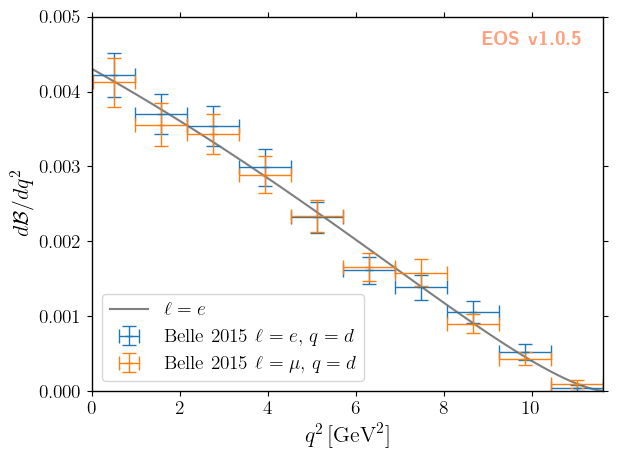

In [2]:
plot_args = {
    'plot': {
        'x': { 'label': r'$q^2$', 'unit': r'$\textnormal{GeV}^2$', 'range': [0.0, 11.63] },
        'y': { 'label': r'$d\mathcal{B}/dq^2$',                    'range': [0.0,  5e-3] },
        'legend': { 'location': 'lower left' }
    },
    'contents': [
        {
            'label': r'$\ell=e$',
            'type': 'observable',
            'observable': 'B->Dlnu::dBR/dq2;l=e,q=d',
            'variable': 'q2',
            'color': 'black',
            'range': [0.02, 11.63],
        },
        {
            'label': r'Belle 2015 $\ell=e,\, q=d$',
            'type': 'constraint',
            'color': 'C0',
            'constraints': 'B^0->D^+e^-nu::BRs@Belle:2015A',
            'observable': 'B->Dlnu::BR',
            'variable': 'q2',
            'rescale-by-width': True
        },
        {
            'label': r'Belle 2015 $\ell=\mu,\,q=d$',
            'type': 'constraint',
            'color': 'C1',
            'constraints': 'B^0->D^+mu^-nu::BRs@Belle:2015A',
            'observable': 'B->Dlnu::BR',
            'variable': 'q2',
            'rescale-by-width': True
        },
    ]
}
eos.plot.Plotter(plot_args).plot()

## Defining the Statistical Analysis

To define our statistical analysis for the inference of $|V_{cb}|$ from measurements
of the $\bar{B}\to D\ell^-\bar\nu$ branching ratios, some decisions are needed.
First, we must decide how to parametrize the hadronic form factors that emerge
in semileptonic $\bar{B}\to D$ transitions.
For what follows we will use the [BSZ:2015A] parametrization.
Next, we must decide the theory input for the form factors. For what follows we will combine the correlated lattice QCD results published by the Fermilab/MILC and HPQCD collaborations in 2015.

We then create an [eos.Analysis](api/python.rst#eos.Analysis) object as follows:

In [3]:
analysis_args = {
    'global_options': { 'form-factors': 'BSZ2015', 'model': 'CKM' },
    'priors': [
        { 'parameter': 'CKM::abs(V_cb)',           'min':  38e-3, 'max':  45e-3 , 'type': 'uniform'},
        { 'parameter': 'B->D::alpha^f+_0@BSZ2015', 'min':  0.0,   'max':  1.0   , 'type': 'uniform'},
        { 'parameter': 'B->D::alpha^f+_1@BSZ2015', 'min': -4.0,   'max': -1.0   , 'type': 'uniform'},
        { 'parameter': 'B->D::alpha^f+_2@BSZ2015', 'min': +4.0,   'max': +6.0   , 'type': 'uniform'},
        { 'parameter': 'B->D::alpha^f0_1@BSZ2015', 'min': -1.0,   'max': +2.0   , 'type': 'uniform'},
        { 'parameter': 'B->D::alpha^f0_2@BSZ2015', 'min': -2.0,   'max':  0.0   , 'type': 'uniform'}
    ],
    'likelihood': [
        'B->D::f_++f_0@HPQCD:2015A',
        'B->D::f_++f_0@FNAL+MILC:2015B',
        'B^0->D^+e^-nu::BRs@Belle:2015A',
        'B^0->D^+mu^-nu::BRs@Belle:2015A'
    ]
}
analysis = eos.Analysis(**analysis_args)
analysis.parameters['CKM::abs(V_cb)'].set(42.0e-3)

INFO:EOS:Creating analysis with 6 priors, 4 EOS-wide constraints, 2 global options, 0 manually-entered constraints and 0 fixed parameters.


INFO:EOS:likelihood probably depends on 48 parameter(s) that do not appear in the prior; check prior?


In the above, the global options ensure that our choice of form factor parametrization is used throughout,
and that for CKM matrix elements the `CKM` model is used. The latter provides parametric access to the
$V_{cb}$ matrix element through two parameters:
the absolute value ``CKM::abs(V_cb)`` and the complex phase ``CKM::arg(V_cb)``.
The latter is not accessible from $b\to c\ell\bar\nu$.
We provide the parameters in our analysis through the specifications of the Bayesian priors.
In the above, each prior is a uniform prior that covers the range from ``min`` to ``max``.
The likelihood is defined through a list constraints, which in the above includes both the experimental measurements by the Belle collaboration as well as the theoretical lattice QCD results.
Finally, we set the starting value of ``CKM::abs(V_cb)`` to a sensible value of $42\cdot 10^{-3}$.

We can now proceed to optimize the log(posterior) through a call to [analysis.optimize](api/python.rst#eos.Analysis.optimize).
In a Jupyter notebook, it is useful to display the return value of this method, which illustrates the best-fit point.
We can further display a summary of fit quality using the [analysis.goodness_of_fit](api/python.rst#eos.Analysis.goodness_of_fit) method.

In [4]:
bfp = analysis.optimize()
display(bfp)
display(analysis.goodness_of_fit())

INFO:EOS:Optimization goal achieved after 122 function evaluations


parameter,value
$|V_{cb}|$,0.0419
"$\alpha_{+,0}^{B \to D,\mathrm{BSZ2015}}$",0.6668
"$\alpha_{+,1}^{B \to D,\mathrm{BSZ2015}}$",-2.5411
"$\alpha_{+,2}^{B \to D,\mathrm{BSZ2015}}$",4.7844
"$\alpha_{0,1}^{B \to D,\mathrm{BSZ2015}}$",0.2558
"$\alpha_{0,2}^{B \to D,\mathrm{BSZ2015}}$",-0.9263


## Sampling from the Posterior

To sample from the posterior, EOS provides the [analysis.sample](api/python.rst#eos.Analysis.sample) method.
Optionally, this can also produce posterior-predictive samples for a list of observables.
We can use these samples to illustrate the results of our fit in comparison to the
experimental constraints.

For this example, we produce such posterior-predictive samples for the differential
$\bar{B}\to D^+e^-\bar\nu$ branching ratio in 40 points in the kinematical variable
$q^2$; the square of the momentum transfer to the $e^-\bar\nu$ pair.
Due to the strong dependence of the branching ratio on $q^2$, we do not distribute the
points equally across the full phase space. Instead, we equally distribute half of
the points in the interval $[0.02\,\text{GeV}^2, 1.00\,\text{GeV}^2]$ and the other
half in the remainder of the phase space.

We produce ``N`` $= 20000$ samples with a thinning factor (or ``stride``) of $5$. This means
that ``stride * N`` $= 100000$ samples are produced, but only every $5$th sample is returned.
This improves the quality of the samples by reducing the autocorrelation.
Before the samples are produced, the Markov Chain self-adapts in a series of preruns,
the number of which is governed by the ``preprun`` argument. In each prerun, ``pre_N``
samples are drawn before the adaptation step. The samples obtained as part of the
preruns are discarded. To ensure efficient sampling, the chain is started in the
best-fit point obtained earlier through optimization.

In [5]:
import numpy as np
e_q2values  = np.unique(np.concatenate((np.linspace(0.02,  1.00, 20), np.linspace(1.00, 11.60, 20))))
e_obs       = [eos.Observable.make(
                  'B->Dlnu::dBR/dq2', analysis.parameters, eos.Kinematics(q2=q2),
                  eos.Options({'form-factors': 'BSZ2015', 'l': 'e', 'q': 'd'}))
              for q2 in e_q2values]
parameter_samples, log_posterior, e_samples  = analysis.sample(N=20000, stride=5, pre_N=3000, preruns=5, start_point=bfp.point, observables=e_obs)

INFO:EOS:Prerun 0 out of 5


INFO:EOS:Prerun 0: acceptance rate is   0%


INFO:EOS:Prerun 1 out of 5


INFO:EOS:Prerun 1: acceptance rate is  56%


INFO:EOS:Prerun 2 out of 5


INFO:EOS:Prerun 2: acceptance rate is  30%


INFO:EOS:Prerun 3 out of 5


INFO:EOS:Prerun 3: acceptance rate is  23%


INFO:EOS:Prerun 4 out of 5


INFO:EOS:Prerun 4: acceptance rate is  25%


INFO:EOS:Main run: started ...


INFO:EOS:Main run: acceptance rate is  25%


The values of the log(posterior) are stored in ``log_posterior``.
The posterior-preditive samples for the observables are stored in ``e_samples``, and are only returned if the ``observables`` keyword argument is provided.

We can plot our result using the `uncertainty` plot type. It expects a `data` item that contains the samples as well as the x-axis values used in the production of the samples. This plot type will interpolate between neighboring x-axis values, and display the $68\%$ probability envelope along the median curve.

(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot: xlabel='$q^2$\\,[$\\textnormal{GeV}^2$]', ylabel='$d\\mathcal{B}/dq^2$'>)

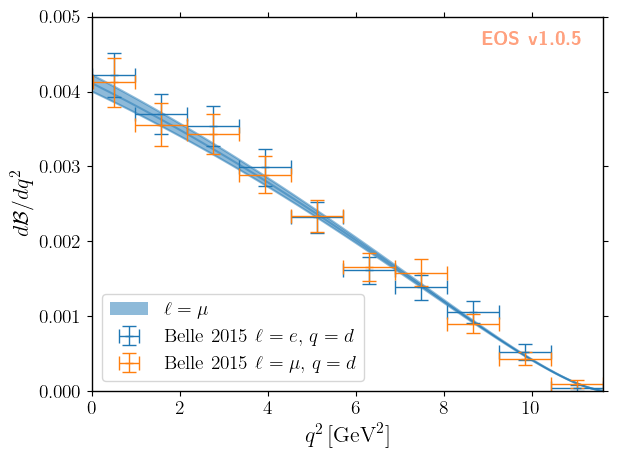

In [6]:
plot_args = {
    'plot': {
        'x': { 'label': r'$q^2$', 'unit': r'$\textnormal{GeV}^2$', 'range': [0.0, 11.63] },
        'y': { 'label': r'$d\mathcal{B}/dq^2$',                    'range': [0.0,  5e-3] },
        'legend': { 'location': 'lower left' }
    },
    'contents': [
        {
          'label': r'$\ell=\mu$', 'type': 'uncertainty', 'range': [0.02, 11.60],
          'data': { 'samples': e_samples, 'xvalues': e_q2values }
        },
        {
            'label': r'Belle 2015 $\ell=e,\, q=d$',
            'type': 'constraint',
            'color': 'C0',
            'constraints': 'B^0->D^+e^-nu::BRs@Belle:2015A',
            'observable': 'B->Dlnu::BR',
            'variable': 'q2',
            'rescale-by-width': True
        },
        {
            'label': r'Belle 2015 $\ell=\mu,\,q=d$',
            'type': 'constraint',
            'color': 'C1',
            'constraints': 'B^0->D^+mu^-nu::BRs@Belle:2015A',
            'observable': 'B->Dlnu::BR',
            'variable': 'q2',
            'rescale-by-width': True
        },
    ]
}
eos.plot.Plotter(plot_args).plot()

The distribution of the parameter samples, here using $|V_{cb}|$ as an example, can be inspected using regular histograms or a smooth histogram based on a kernel density estimate (KDE). For the latter, the parameter ``bandwidth`` regulates the smoothing. EOS applies a relative bandwidth factor with respect to SciPy's best bandwidth estimate, i.e., specifying `'bandwidth': 2` double SciPy's estimate for the bandwidth.

(<Figure size 640x480 with 1 Axes>, <AxesSubplot: xlabel='$|V_{cb}|$'>)

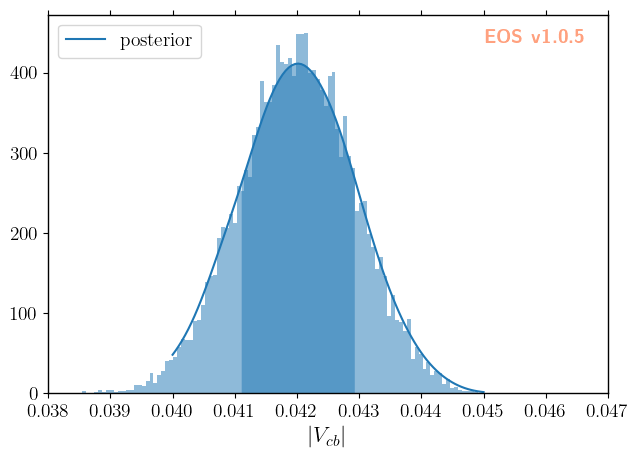

In [7]:
plot_args = {
    'plot': {
        'x': { 'label': r'$|V_{cb}|$', 'range': [38e-3, 47e-3] },
        'legend': { 'location': 'upper left' }
    },
    'contents': [
        {
            'type': 'histogram',
            'data': { 'samples': parameter_samples[:, 0] }
        },
        {
            'type': 'kde', 'color': 'C0', 'label': 'posterior', 'bandwidth': 2,
            'range': [40e-3, 45e-3],
            'data': { 'samples': parameter_samples[:, 0] }
        }
    ]
}
eos.plot.Plotter(plot_args).plot()

We can also illustrate the correlation between $|V_{cb}|$ and any form factor parameter. Her, we use the normalization of the form factors at $q^2 = 0$ as an example. Contours of equal probability at the $68\%$
and $95\%$ levels can be generated using a KDE as follows:

(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot: xlabel='$|V_{cb}|$', ylabel='$f_+(0)$'>)

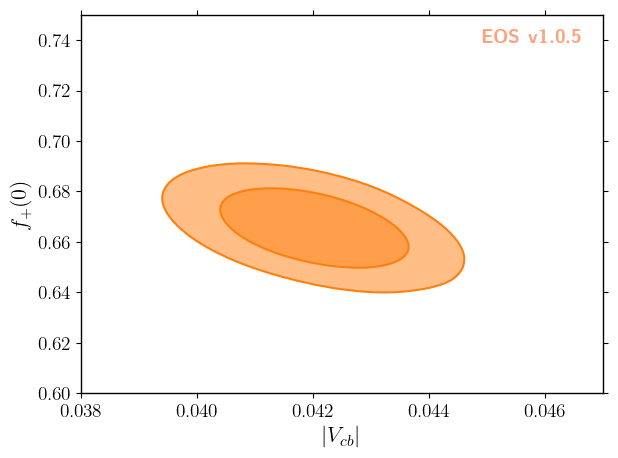

In [8]:
plot_args = {
    'plot': {
        'x': { 'label': r'$|V_{cb}|$', 'range': [38e-3, 47e-3] },
        'y': { 'label': r'$f_+(0)$',   'range': [0.6, 0.75] },
    },
    'contents': [
        {
            'type': 'kde2D', 'color': 'C1', 'label': 'posterior',
            'levels': [68, 95], 'contours': ['lines','areas'], 'bandwidth':3,
            'data': { 'samples': parameter_samples[:, (0,1)] }
        }
    ]
}
eos.plot.Plotter(plot_args).plot()

Here the `bandwidth` parameter takes the same role as in the 1D histogram.

We can compute the mean value and its standard deviation using ``numpy`` methods

In [9]:
print('$|V_{{cb}}|$ = {mean:.4f} +/- {std:.4f}'.format(
    mean=np.average(parameter_samples[:,0]),
    std=np.std(parameter_samples[:, 0])
))

$|V_{cb}|$ = 0.0420 +/- 0.0009
